# Regional MOM6 NWA marine heatwave
- using the reforecast(hindcast) of regional mom6 to investigate the marine heatwave in NWA 
- the climatology period is set to 1993-2023 (30 years)

## Calculate Period Specific Climatology

In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client
from mom6.mom6_module import mom6_io
from mom6.mom6_module import mom6_statistics
from mom6.mom6_module import mom6_mhw

In [2]:
### open local cluster
client = Client(processes=False)
print(client)
print(client.cluster.dashboard_link)

<Client: 'inproc://10.173.16.4/152725/1' processes=1 threads=96, memory=0.98 TiB>
http://10.173.16.4:41467/status


In [3]:
FORECAST = mom6_io.MOM6Forecast(
    var='tos',
    data_relative_dir='forecast/',
    static_relative_dir='static/',
    grid='raw',
    source='local')

In [4]:
ds_forecast = FORECAST.get_all()
ds_forecast = ds_forecast.rename({'geolon':'lon','geolat':'lat'})

In [5]:
class_forecast_climo = mom6_statistics.ForecastClimatology(ds_forecast,'tos')
da_climo = class_forecast_climo.generate_climo(1993,2022,'compute')

In [6]:
da_anom = ds_forecast['tos'].groupby('init.month')-da_climo
ds_anom = xr.Dataset()
ds_anom['tos'] = da_anom.persist()

In [7]:
class_forecast_quantile = mom6_statistics.ForecastQuantile(ds_forecast,'tos')
da_threshold = class_forecast_quantile.generate_quantile(1993,2022,90)

In [ ]:
class_mhw = mom6_mhw.MarineHeatwaveForecast(ds_forecast,'tos')
ds_mhw_single = class_mhw.generate_forecast_single('2022-03',da_climo,da_threshold)

<xarray.DataArray 'tos' (month: 4, lead: 12, yh: 845, xh: 775)> Size: 126MB
array([[[[       nan,        nan,        nan, ..., 27.009989 ,
          27.019514 , 27.032867 ],
         [       nan,        nan,        nan, ..., 27.00194  ,
          27.011576 , 27.022558 ],
         [       nan,        nan,        nan, ..., 26.991453 ,
          27.000628 , 27.01015  ],
         ...,
         [       nan,        nan,        nan, ...,  4.792766 ,
           4.805158 ,  4.8085427],
         [       nan,        nan,        nan, ...,  4.772153 ,
           4.777704 ,  4.778551 ],
         [       nan,        nan,        nan, ...,  4.716612 ,
           4.7133594,  4.7083683]],

        [[       nan,        nan,        nan, ..., 27.236385 ,
          27.24528  , 27.263268 ],
         [       nan,        nan,        nan, ..., 27.217203 ,
          27.22629  , 27.24082  ],
         [       nan,        nan,        nan, ..., 27.200031 ,
          27.20846  , 27.220451 ],
...
         [       nan,        nan,        nan, ...,  8.9111395,
           8.98242  ,  8.993536 ],
         [       nan,        nan,        nan, ...,  8.852629 ,
           8.935037 ,  8.968702 ],
         [       nan,        nan,        nan, ...,  8.679799 ,
           8.779358 ,  8.859502 ]],

        [[       nan,        nan,        nan, ..., 28.323544 ,
          28.321049 , 28.315874 ],
         [       nan,        nan,        nan, ..., 28.366644 ,
          28.365002 , 28.359968 ],
         [       nan,        nan,        nan, ..., 28.387798 ,
          28.38687  , 28.382345 ],
         ...,
         [       nan,        nan,        nan, ...,  7.5440893,
           7.5988173,  7.5951824],
         [       nan,        nan,        nan, ...,  7.5031343,
           7.5710964,  7.5855684],
         [       nan,        nan,        nan, ...,  7.3512073,
           7.438815 ,  7.4958115]]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
    lon      (yh, xh) float32 3MB 262.0 262.1 262.2 262.2 ... 322.6 322.7 322.8
    lat      (yh, xh) float32 3MB 5.273 5.273 5.273 5.273 ... 58.15 58.16 58.16
  * lead     (lead) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * month    (month) int64 32B 3 6 9 12
Attributes:
    units:                  degC
    long_name:              Sea Surface Temperature
    cell_methods:           area:mean yh:mean xh:mean time: mean
    time_avg_info:          average_T1,average_T2,average_DT
    standard_name:          sea_surface_temperature
    period_of_climatology:  year 1993 to 2022

In [7]:
ds_mhw_batch = class_mhw.generate_forecast_batch(1993,2022,1993,2022,90)

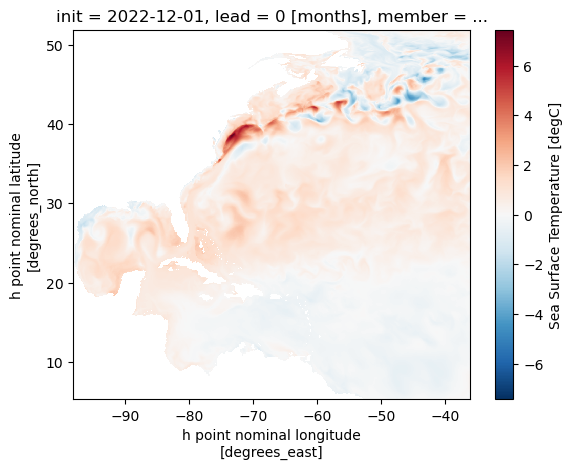

In [8]:
da_anom.isel(init=-1,member=0,lead=0).plot()

In [15]:
da_anom

<xarray.DataArray 'tos' (init: 120, member: 10, lead: 12, yh: 845, xh: 775)> Size: 38GB
dask.array<sub, shape=(120, 10, 12, 845, 775), dtype=float32, chunksize=(1, 10, 12, 845, 775), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
    lon      (yh, xh) float32 3MB 262.0 262.1 262.2 262.2 ... 322.6 322.7 322.8
    lat      (yh, xh) float32 3MB 5.273 5.273 5.273 5.273 ... 58.15 58.16 58.16
  * init     (init) datetime64[ns] 960B 1993-03-01 1993-06-01 ... 2022-12-01
  * lead     (lead) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * member   (member) int32 40B 1 2 3 4 5 6 7 8 9 10
    month    (init) int32 480B 3 6 9 12 3 6 9 12 3 6 ... 9 12 3 6 9 12 3 6 9 12
Attributes:
    units:                  degC
    long_name:              Sea Surface Temperature
    cell_methods:           area:mean yh:mean xh:mean time: mean
    time_avg_info:          average_T1,average_T2,average_DT
    standard_name:          sea_surface_temperature
    period_of_climatology:  year 1993 to 2022

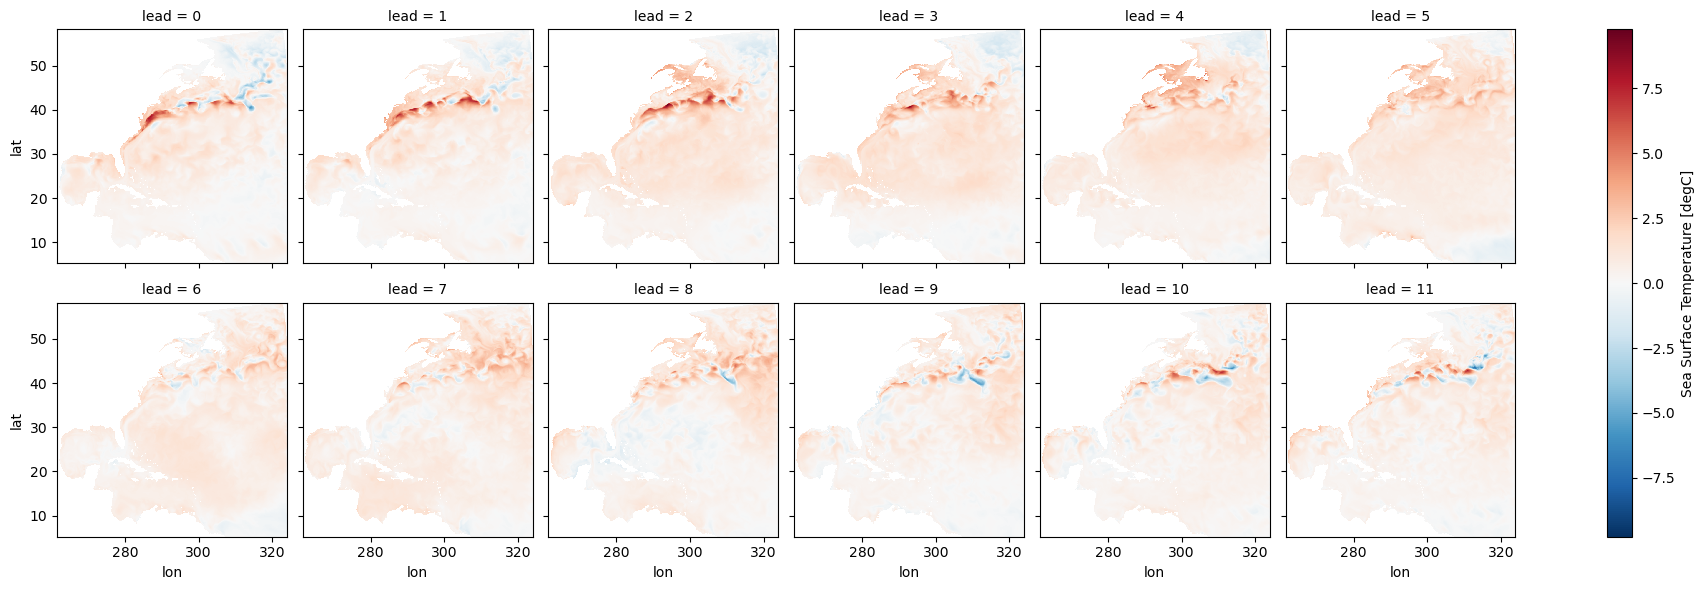

In [16]:
da_anom.sel(member=1).sel(init='2022-03').plot(x='lon',y='lat',col='lead',col_wrap=6)

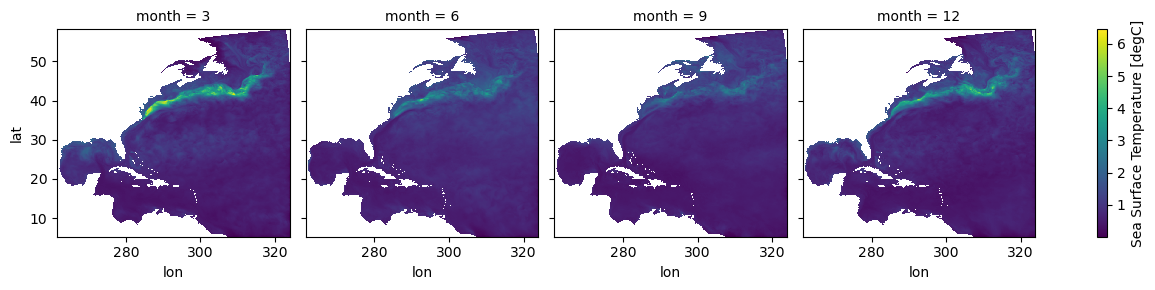

In [26]:
da_threshold.sel(lead=0).plot(x='lon',y='lat',col='month')

In [20]:
da_mhw = da_anom.sel(init='2022-03').where(da_anom.sel(init='2022-03')>=da_threshold.sel(month=3)).compute()

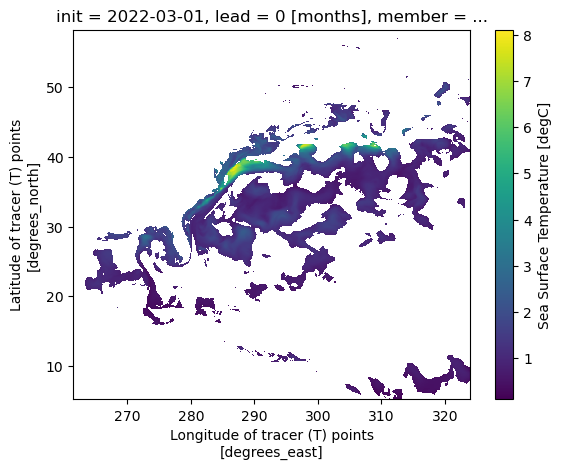

In [27]:
da_mhw.sel(member=1, lead=0).plot(x='lon',y='lat')

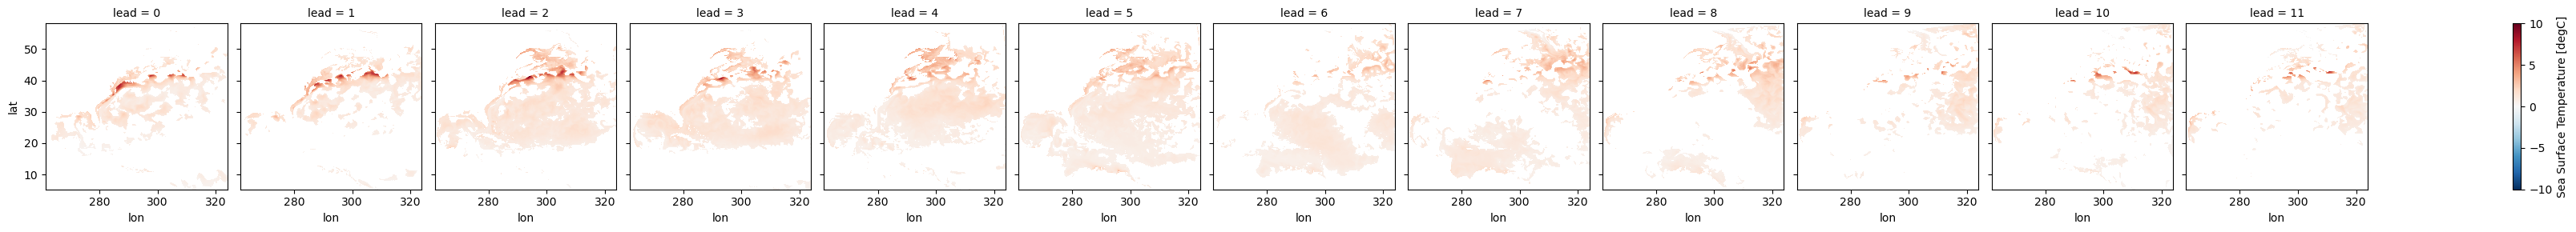

In [23]:
da_mhw.sel(member=1).plot(x='lon',y='lat',col='lead',vmin=-10,vmax=10,cmap='RdBu_r')

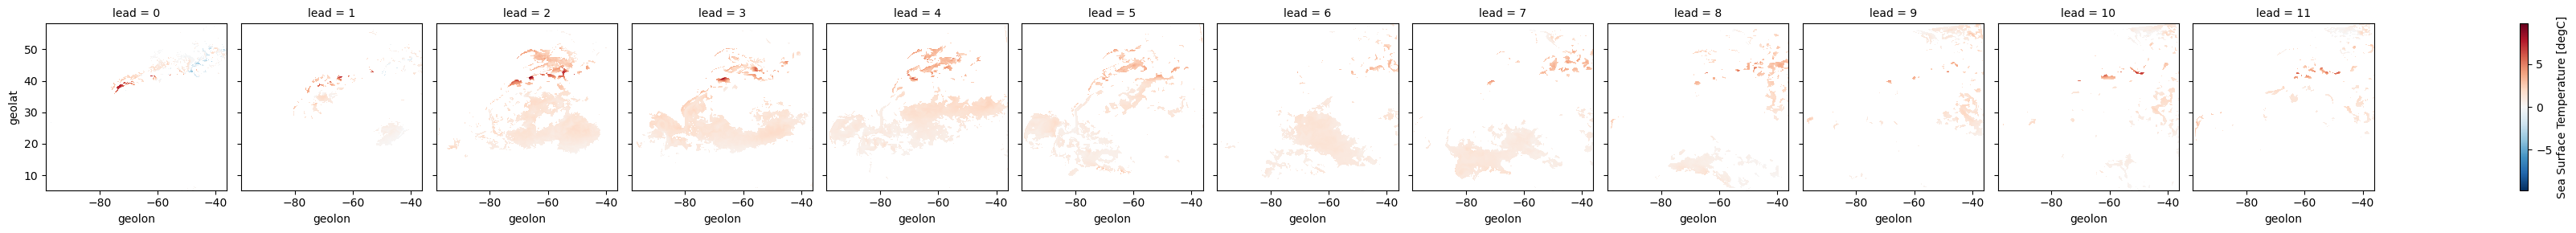

In [18]:
da_mhw.sel(member=1).plot(x='geolon',y='geolat',col='lead')